In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold #Something to split and randomise the data 

from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score



from sklearn import linear_model
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier

In [2]:
data = pd.read_csv('Credit/creditdefault_train.csv') #Putting the test data and the train data in data frames 
test = pd.read_csv('Credit/creditdefault_test.csv')

#Seperating the train data labels from the inputs:
y_train = data['Y']
x_train = data.drop(['Y'],axis=1)

#Seperating the test data labels from the inputs:
y_test = test['Y']
x_test = test.drop(['Y'],axis=1)

kf = StratifiedKFold(n_splits=3)
#kf = KFold(15000, n_folds=3)



In [12]:
def visualise(train_acc,train_d,train_p,test_acc,test_d,test_p,dependant_var,dependant_label):
    """Visualisation of train/test accuracy and precision"""
    fig,axs = plt.subplots(3,1,figsize=(12,6))
    print(test_acc)
    print(test_d)
    print(test_p)
    axs[0].plot(dependant_var,train_acc,'ro-',dependant_var,test_acc,'bv--')
    axs[0].legend(['Training Accuracy','Test Accuracy'])
    axs[0].set_xlabel(dependant_label)
    axs[0].set_ylabel('Accuracy')
    
    axs[1].plot(dependant_var,train_d,'ro-',dependant_var,test_d,'bv--')
    axs[1].legend(['Training default precision','Test default precision'])
    axs[1].set_xlabel(dependant_label)
    axs[1].set_ylabel('Default precision')
    
    axs[2].plot(dependant_var,train_p,'ro-',dependant_var,test_p,'bv--')
    axs[2].legend(['Training payment precision','Test payment precision'])
    axs[2].set_xlabel(dependant_label)
    axs[2].set_ylabel('payment precision')
    

Whats consuming the most time is the fitting of the data.

In [4]:
def bag(depth, bootstrap_, bootstrap_features, est_, max_feat):   
    train_metrics_mean = np.zeros(3) #Place to store the mean of accuracy, defualt and payment precision 
    

    train_metrics = np.zeros((3,3)) #3x3 matrix to store current train accuracy 
    
    test_metrics = np.zeros(3)  #Place to store test accuracy of that model

    counter = 0
    for train_index, test_index in kf.split(x_train,y_train):# Splitting into three folds 

        #Taking the elements and putting them into array:
        temp_train_x = np.take(x_train,train_index,0)
        temp_train_y = np.take(y_train,train_index,0)

        temp_test_x = np.take(x_train,test_index,0)
        temp_test_y = np.take(y_train,test_index,0)

        #Building model
        bagging_loc = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=depth),n_estimators=500,
                                         bootstrap=bootstrap_, bootstrap_features=bootstrap_features,n_jobs=-1)

        
        #Fitting model
        bagging_loc.fit(temp_train_x,temp_train_y)
        #Creating predictions
        pred = bagging_loc.predict(temp_train_x)
        
        #Storing the metrics of current fold
        train_metrics[counter][0] = accuracy_score(pred,temp_train_y)
        train_metrics[counter][1] = precision_score(pred,temp_train_y)
        train_metrics[counter][2] = precision_score(pred,temp_train_y,pos_label=0)
        
        counter+=1
    
    #Working out the mean of the outputs
    train_metrics_mean = np.mean(train_metrics,axis=0)  ## Working out the mean
    
    #Tesing on the full data set and test set
    
    main_bagging_loc = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=depth),n_estimators=est_,
                                         bootstrap=bootstrap_, bootstrap_features=bootstrap_features,n_jobs=-1)

        
    main_bagging_loc.fit(x_train,y_train)
    
    prediction = main_bagging_loc.predict(x_test)
    #Storing the metrics on test set
    test_metrics[0] = accuracy_score(prediction,y_test)
    test_metrics[1] = precision_score(prediction,y_test)
    test_metrics[2] = precision_score(prediction,y_test,pos_label=0)
    
    return (train_metrics_mean,test_metrics) #Returning two arrays filled with elements
    
    

In [5]:
def bagging(bootstrap_,bootstrap_features,max_feat):
    '''Easy function to develop and tune the hyperparameters of bagging'''
    #Places to store the metrics to judge by:
    train_acc = []  #Train accuracy score 
    train_d = []    #Train Default precision
    train_p = []    #Train payment precision


    test_acc = []    #Test accuracy score 
    test_d = []      #Test default precision
    test_p = []      #Test Payment precison

    dependant = [10,50,100,200,500,750,1000] #A place to iterate how many mini decision trees based on the bagged data 
    for i in dependant: #Going through num of estimators
        train,test = bag(10,bootstrap_,bootstrap_features,i,max_feat) #Building the model with different hyperparameters

        #Storing the elements in the different arrays:
        #Train elements
        train_acc.append(train[0])
        train_d.append(train[1])
        train_p.append(train[2])

        #Test elements
        test_acc.append(test[0])
        test_d.append(test[1])
        test_p.append(test[2])

    visualise(train_acc,train_d,train_p,
              test_acc,test_d,test_p,dependant,'estimators')

## Gini

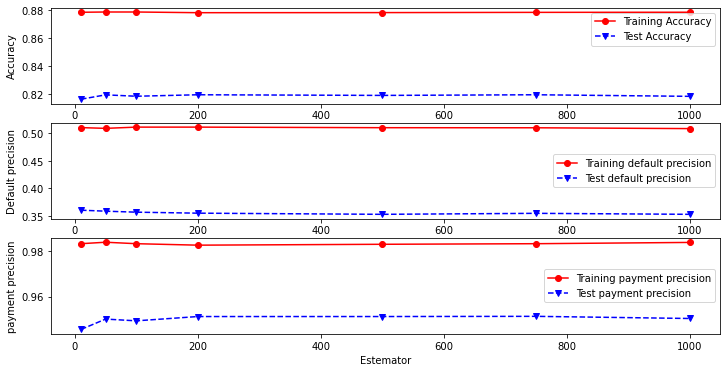

In [6]:
bagging(True,False,1)

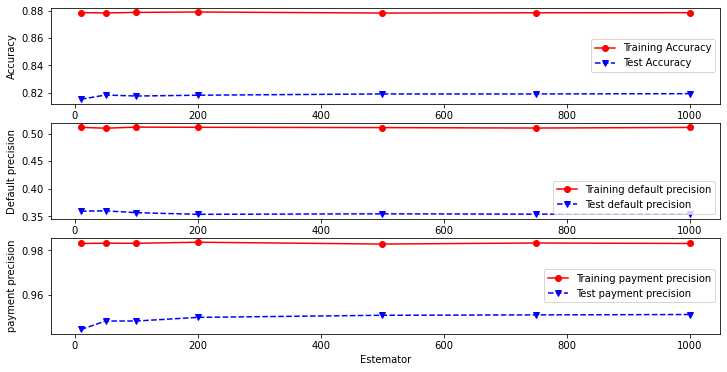

In [7]:
bagging(True,False,0.5)

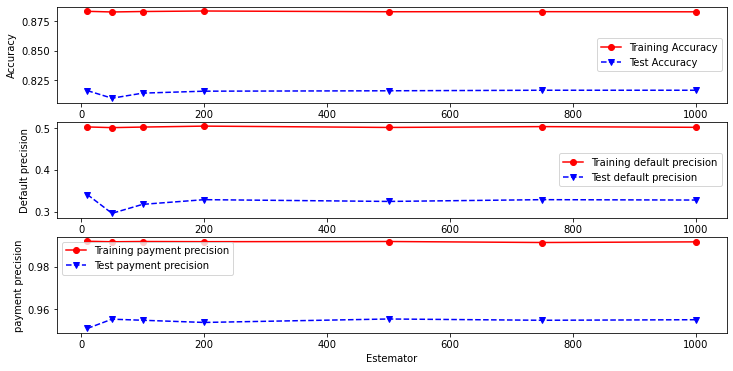

In [8]:
bagging(True,True,1.0)

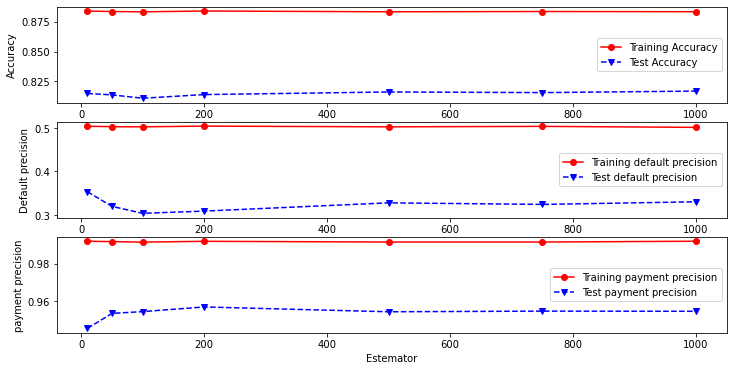

In [9]:
bagging(True,True,0.5)

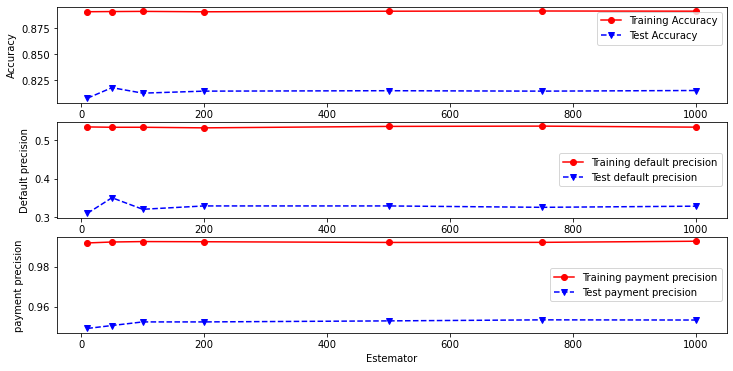

In [10]:
bagging(False,True,1.0)

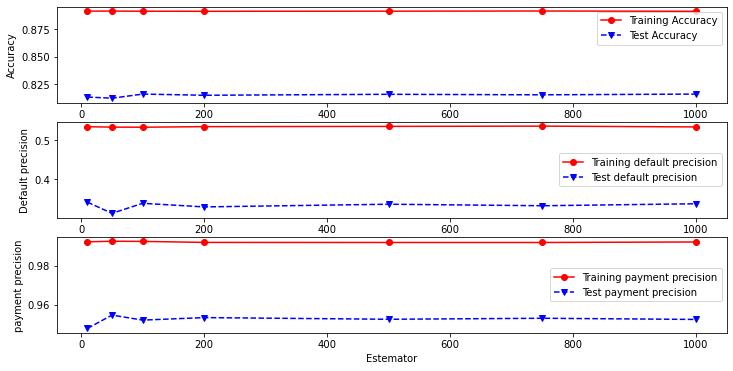

In [11]:
bagging(False,True,0.5)

Testing overfits immediately when it comes to precision for defaults